## Coordinate aliasing

When loading volumetric data into yt from xarray, there are a number of situations that may need some extra handling. 

1. The first situation is when the data contain a time dimensions (as is common in many cf-compliant netcdfs). In this case, we'll need to select the time to load into yt. 
2. It is also possible that the coordinates for a variable may not be recognized by yt, in which case we need to tell yt how to interpret those coordinates. 


We'll demonstrate this once again using random data:

In [1]:
import xarray as xr
import yt_xarray
import yt
from yt_xarray.sample_data import load_random_xr_data

fields = {'temp': ('h1', 'b2', 'c1'), 
          'precip': ('h1', 'b2'),
          'precip_t': ('h1', 'b2', 'time')}
dims = {'h1': (0,1,15), 'b2': (0, 1, 10), 'c1': (0, 1, 15), 'time': (0, 1, 5)}
ds = load_random_xr_data(fields, dims, length_unit='m')

because these coordinates do not match up with those used by yt, simply trying

```python
yt_ds = ds.yt.load_uniform_grid(fields=['temp'])
```

will result in the following error:

```
ValueError: h1 is not a known coordinate. To load in yt, you must supply an alias via the yt_xarray.known_coord_aliases dictionary.
```
This is telling us that to load data into yt, we need to explain how to map our dimension names to those expected by yt. 

If our dataset is cartesian, we can do so by adding some mappings to the `yt_xarray.known_coord_aliases` dictionary. The keys here are your native dataset names, while the values are the expected yt name:

In [2]:
yt_xarray.known_coord_aliases['h1'] = 'y'
yt_xarray.known_coord_aliases['b2'] = 'x'
yt_xarray.known_coord_aliases['c1'] = 'z'

now we can load up the data:

In [3]:
yt_ds = ds.yt.load_grid(fields=['temp'])

yt_xarray : [INFO ] 2024-04-03 16:33:53,933:  Inferred geometry type is cartesian. To override, use ds.yt.set_geometry
yt_xarray : [INFO ] 2024-04-03 16:33:53,933:  Attempting to detect if yt_xarray will require field interpolation:
yt_xarray : [INFO ] 2024-04-03 16:33:53,933:      Cartesian geometry on uniform grid: yt_xarray will not interpolate.
yt : [INFO     ] 2024-04-03 16:33:53,959 Parameters: current_time              = 0.0
yt : [INFO     ] 2024-04-03 16:33:53,960 Parameters: domain_dimensions         = [15 10 15]
yt : [INFO     ] 2024-04-03 16:33:53,960 Parameters: domain_left_edge          = [-0.03571429 -0.05555556 -0.03571429]
yt : [INFO     ] 2024-04-03 16:33:53,960 Parameters: domain_right_edge         = [1.03571429 1.05555556 1.03571429]
yt : [INFO     ] 2024-04-03 16:33:53,961 Parameters: cosmological_simulation   = 0


Note that from here, you'll have to use the yt name within yt commands:

yt : [INFO     ] 2024-04-03 16:33:54,007 xlim = -0.055556 1.055556
yt : [INFO     ] 2024-04-03 16:33:54,007 ylim = -0.035714 1.035714
yt : [INFO     ] 2024-04-03 16:33:54,008 xlim = -0.055556 1.055556
yt : [INFO     ] 2024-04-03 16:33:54,008 ylim = -0.035714 1.035714
yt : [INFO     ] 2024-04-03 16:33:54,012 Making a fixed resolution buffer of (('stream', 'temp')) 800 by 800



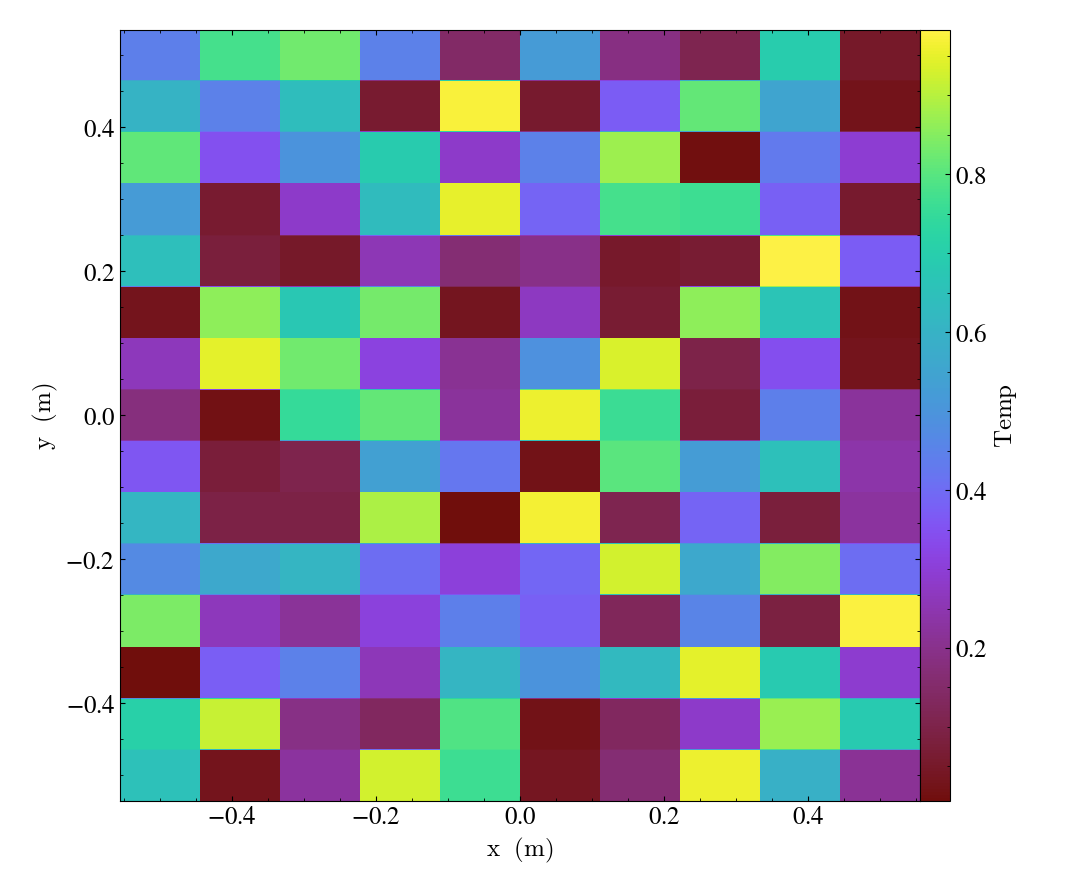

In [4]:
slc = yt.SlicePlot(yt_ds, 'z', ('stream', 'temp'))
slc.set_log(('stream', 'temp'), False)

## cf-compliant coordinate names

Additionally, the conversion of xarray coordinate name to the expected yt name can use [cf_xarray](https://cf-xarray.readthedocs.io) in the process of disambiguation. Note that this will only work if cf_xarray is installed (`pip install cf_xarray`). 


First, let's import a cf_xarray sample dataset and checkout the `air` variable:


In [5]:
from cf_xarray.datasets import airds
airds.air

<xarray.DataArray 'air' (time: 4, lat: 25, lon: 50)>
[5000 values with dtype=float32]
Coordinates:
  * lat        (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 22.5 20.0 17.5 15.0
  * lon        (lon) float32 200.0 202.5 205.0 207.5 ... 315.0 317.5 320.0 322.5
  * time       (time) datetime64[ns] 2013-01-01 ... 2013-01-01T18:00:00
    cell_area  (lat, lon) float32 2.989e+09 2.989e+09 ... 1.116e+10 1.116e+10
Attributes: (12/13)
    long_name:      4xDaily Air temperature at sigma level 995
    units:          degK
    precision:      2
    GRIB_id:        11
    GRIB_name:      TMP
    var_desc:       Air temperature
    ...             ...
    level_desc:     Surface
    statistic:      Individual Obs
    parent_stat:    Other
    actual_range:   [185.16 322.1 ]
    cell_measures:  area: cell_area
    standard_name:  air_temperature

the 'lat' and 'lon' variables are mapped to standard names via attributes:

In [6]:
airds.lon

<xarray.DataArray 'lon' (lon: 50)>
array([200. , 202.5, 205. , 207.5, 210. , 212.5, 215. , 217.5, 220. , 222.5,
       225. , 227.5, 230. , 232.5, 235. , 237.5, 240. , 242.5, 245. , 247.5,
       250. , 252.5, 255. , 257.5, 260. , 262.5, 265. , 267.5, 270. , 272.5,
       275. , 277.5, 280. , 282.5, 285. , 287.5, 290. , 292.5, 295. , 297.5,
       300. , 302.5, 305. , 307.5, 310. , 312.5, 315. , 317.5, 320. , 322.5],
      dtype=float32)
Coordinates:
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 315.0 317.5 320.0 322.5
Attributes:
    standard_name:  longitude
    long_name:      Longitude
    units:          degrees_east
    axis:           X

we'll load in the first time step, which for refernce looks like:

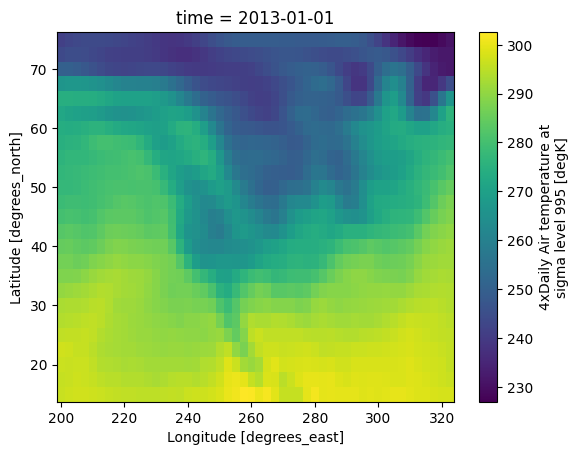

In [7]:
airds.air.isel({'time':0}).plot()

In [8]:
airds.lon.attrs

{'standard_name': 'longitude',
 'long_name': 'Longitude',
 'units': 'degrees_east',
 'axis': 'X'}

since 'lat' and 'lon' are in the base `known_coord_aliases`, let's remove them (after first resetting the dictionary):

In [9]:
yt_xarray.reset_coordinate_aliases()
_ = yt_xarray.known_coord_aliases.pop('lat')
_ = yt_xarray.known_coord_aliases.pop('lon')

and now when we go to load a yt dataset, yt_xarray will use cf_xarray to determine that 'lat' and 'lon' should point to latitude and longitude, respectively.

But first... as of this writing, there is a bug in handling longitude ranges, so we'll first adjust the longitude values to be degrees west ([bug report here](https://github.com/data-exp-lab/yt_xarray/issues/85)). The following copies over the original attributes after modifying the longitude variable:

In [10]:
attrs = airds.lon.attrs.copy()
airds['lon'] = airds.lon.values - 360.
airds.lon.attrs.update(attrs)

yt_xarray : [INFO ] 2024-04-03 16:33:55,041:  Inferred geometry type is geodetic. To override, use ds.yt.set_geometry
yt_xarray : [INFO ] 2024-04-03 16:33:55,045:  Attempting to detect if yt_xarray will require field interpolation:
yt_xarray : [INFO ] 2024-04-03 16:33:55,048:      Geodetic geometry on uniform grid within geodetic bounds: yt_xarray will not interpolate.
yt : [INFO     ] 2024-04-03 16:33:55,104 Parameters: current_time              = 1.3569984e+18
yt : [INFO     ] 2024-04-03 16:33:55,106 Parameters: domain_dimensions         = [25 50  1]
yt : [INFO     ] 2024-04-03 16:33:55,107 Parameters: domain_left_edge          = [  13.75 -161.25   -0.5 ]
yt : [INFO     ] 2024-04-03 16:33:55,108 Parameters: domain_right_edge         = [ 76.25 -36.25   0.5 ]
yt : [INFO     ] 2024-04-03 16:33:55,108 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-04-03 16:33:55,135 xlim = -161.250000 -36.250000
yt : [INFO     ] 2024-04-03 16:33:55,136 ylim = 13.750000 76.250000
yt : [IN


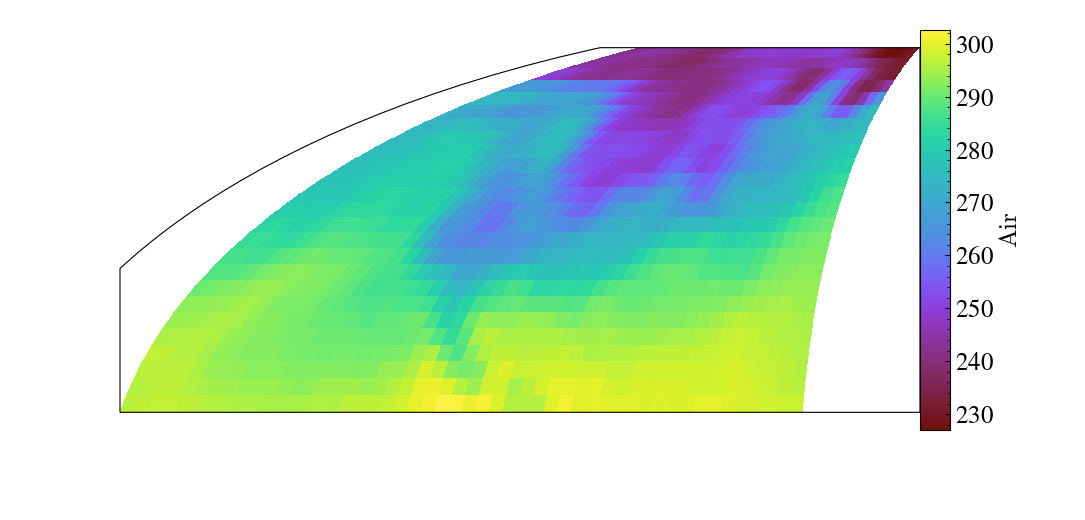

In [11]:
ds_yt = airds.yt.load_grid('air', sel_dict={'time':0}, geometry='geographic', use_callable=False)
slc = yt.SlicePlot(ds_yt, 'altitude', 'air')
slc.set_log('air', False)